<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/02-Machine-Learning/notebooks/12-Clasificacion-Desbalanceo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica *Final* de Clasificación

En esta notebook entrenaremos clasificación con un dataset difícil.

<h3>Descripción del dataset</h3>
Este dataset contiene 284,807 transacciones con tarjetas de crédito, de las cuales solo 492 (0.172%) son fraudulentas, lo que lo convierte en un caso extremadamente desbalanceado. Las 30 features disponibles son el resultado de una transformación mediante PCA (Análisis de Componentes Principales) para preservar la confidencialidad de los datos. Las únicas columnas sin transformar son Time (segundos transcurridos desde la primera transacción) y Amount (monto de la transacción).

<h3>Problema a Resolver</h3>
El objetivo es clasificar transacciones fraudulentas con alta precisión, minimizando los falsos negativos (transacciones fraudulentas no detectadas) sin afectar demasiado los falsos positivos (transacciones legítimas marcadas como fraudulentas).

<h3>Dificultades Principales</h3>

* Desbalance extremo (fraudes ≈ 0.17% del total).
* Features anonimizadas (no interpretables directamente).
* Alto costo de error:
 * Falsos negativos → Pérdidas económicas.
 * Falsos positivos → Mala experiencia del cliente.


<h3>Técnicas Recomendadas</h3>

1. Manejo de desbalance:
 * Undersampling (reducir la clase mayoritaria).
 * Oversampling (SMOTE, ADASYN) para generar fraudes sintéticos.
 * Pesado de clases (class_weight en modelos).

2. Selección de métricas:
 * Precision-Recall > Accuracy (por el desbalance).
 * AUC-ROC y F1-Score.

3. Modelos adecuados:
 * Regresión Logística (con regularización L1/L2).
 * Random Forest / XGBoost (manejo automático de desbalance).
 * Autoencoders (pendiente...)

**Información del dataset**

Los conjuntos de datos contienen transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos. Este conjunto de datos presenta transacciones que ocurrieron en dos días, donde tenemos 492 fraudes de 284,807 transacciones. El conjunto de datos está altamente desequilibrado, la clase positiva (fraudes) representa el 0.172% de todas las transacciones.

Contiene solo variables de entrada numéricas que son el resultado de una transformación PCA. Debido a cuestiones de confidencialidad, no se pueden obtener las características originales y más información sobre los datos. Las características $V_1$, $V_2$, ..., $V_{28}$ son los componentes principales obtenidos con PCA, las únicas características que no se han transformado con PCA son 'Tiempo' y 'Cantidad'. La función 'Tiempo' contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La característica 'Cantidad' es la Cantidad de la transacción. La característica 'Clase' es la variable de respuesta y toma el valor 1 en caso de fraude y 0 en caso contrario.


Recordemos las buenas prácticas del Machine Learning: https://scikit-learn.org/stable/common_pitfalls.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Descargamos el dataset

In [3]:
!gdown 1k0cJMf8bEoi2esrcbwr7gI9rXmBiTlfG

Downloading...
From (original): https://drive.google.com/uc?id=1k0cJMf8bEoi2esrcbwr7gI9rXmBiTlfG
From (redirected): https://drive.google.com/uc?id=1k0cJMf8bEoi2esrcbwr7gI9rXmBiTlfG&confirm=t&uuid=d7aab596-f016-472c-97f1-15b5b68926f0
To: /content/creditcard.zip
100% 66.4M/66.4M [00:02<00:00, 31.3MB/s]


Extraer el archivo zip

In [4]:
import numpy as np
from zipfile import ZipFile
import pandas as pd

archivo = "creditcard.zip"

print('Extrayendo contenido...')
with ZipFile(archivo, 'r') as Zip:
    Zip.extractall()
    print('Extracción finalizada.')

credito_df = pd.read_csv("creditcard.csv")

Extrayendo contenido...
Extracción finalizada.


## Análisis Exploratorio

Las 30 features disponibles son el resultado de una transformación mediante PCA para preservar la confidencialidad de los datos. Las únicas columnas sin transformar son Time (segundos transcurridos desde la primera transacción) y Amount (monto de la transacción).

<center>
<p><img src="https://drive.google.com/uc?id=1gURkWL4aU4ogu6YxbX7LzaIZOWbkoVj9" width="300" /></p>
</center>

Forma del dataset:

In [5]:
print(f"Tamaño del dataset: {credito_df.shape}")
credito_df.head()

Tamaño del dataset: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Exploremos los rangos de las variables

In [6]:
credito_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Como podemos ver tenemos rangos muy distintos en las variables

<Figure size 640x480 with 0 Axes>

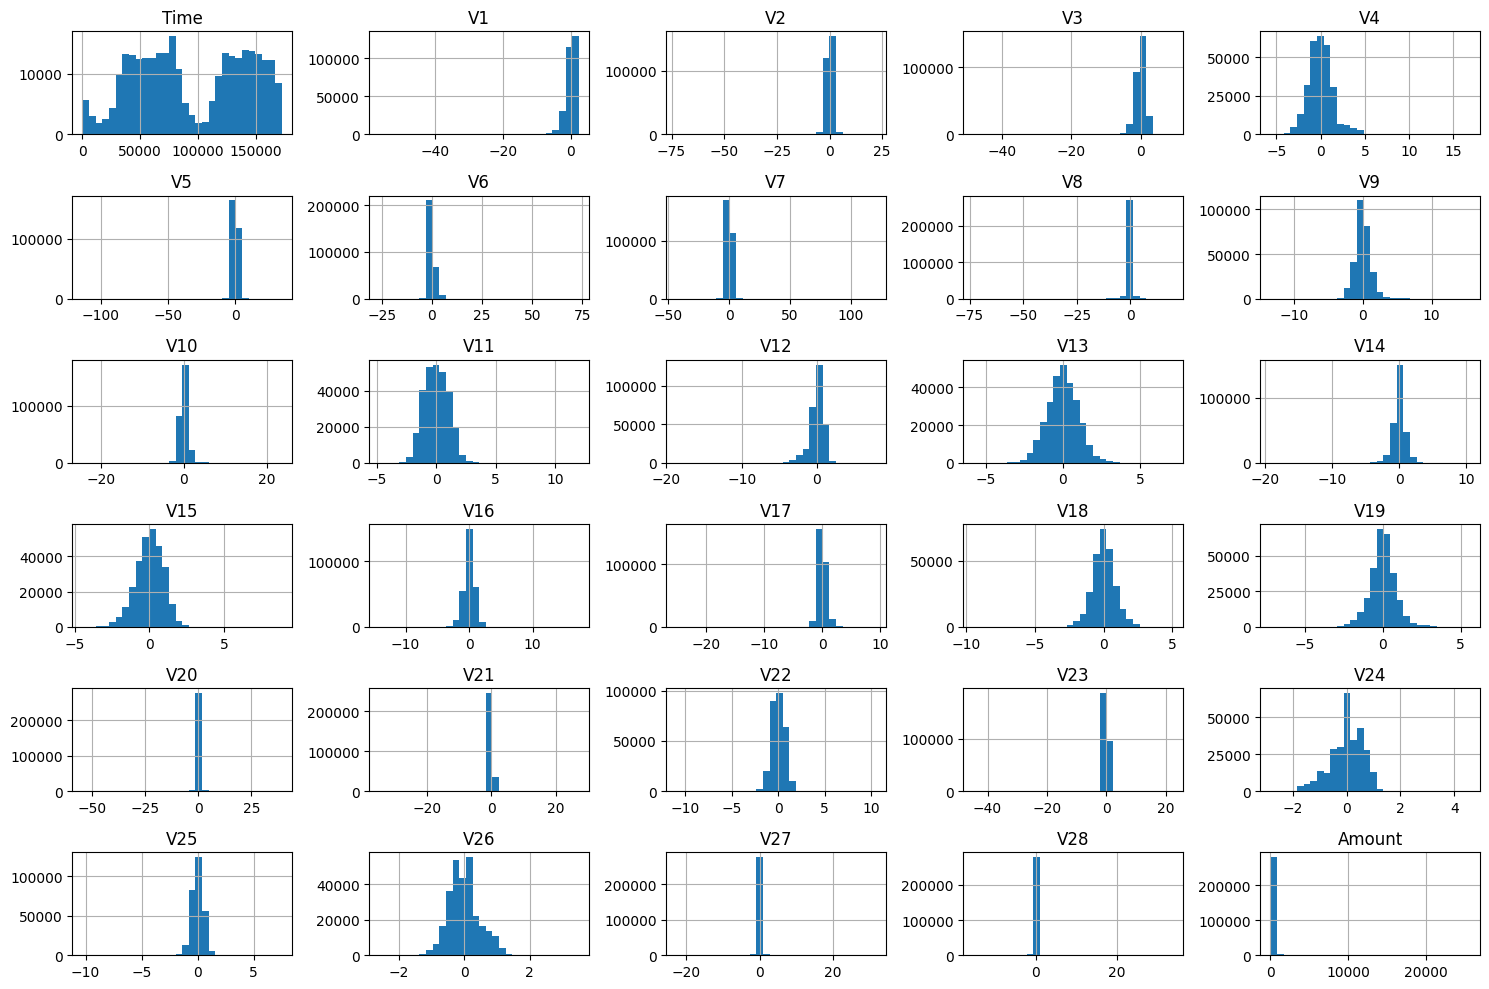

In [7]:
from seaborn import histplot

cols_to_plot = credito_df.columns.to_list()[:-1]

plt.figure()
credito_df[cols_to_plot].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

Podemos notar algunos patrones en los datos:

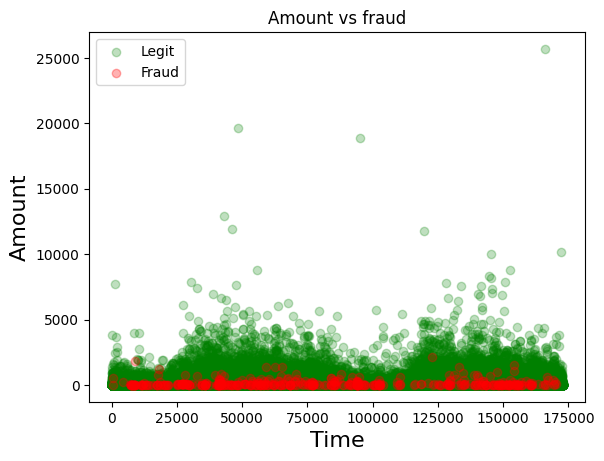

In [9]:
import matplotlib.pyplot as plt

plt.figure()

# Graficamos los que no son fraude
time_amount = credito_df[credito_df['Class'] == 0][['Time','Amount']].values
plt.scatter(time_amount[:,0], time_amount[:,1],
            c='green',alpha=0.25,label='Legit')
# Graficamos los que sí son fraude
time_amount = credito_df[credito_df['Class'] == 1][['Time','Amount']].values
plt.scatter(time_amount[:,0], time_amount[:,1],
            c='red',label='Fraud',alpha=0.3)
plt.legend(loc='best')
plt.title('Amount vs fraud')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Amount', fontsize=16)
plt.show()

Veamos la distribución de clases y el ratio, la razón entre la clase positiva y el total

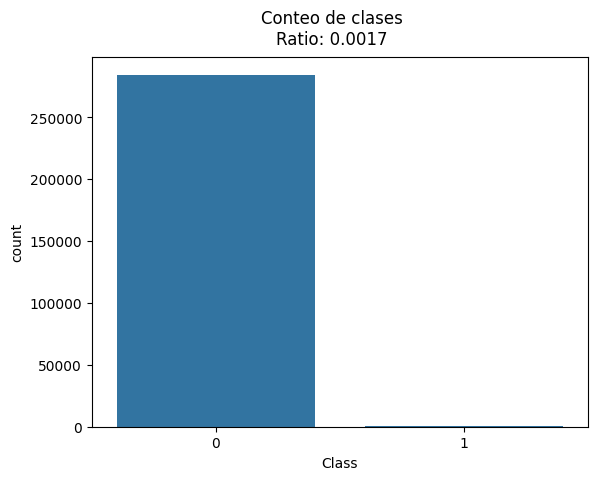

In [ ]:
import seaborn as sns

ratio = credito_df[credito_df['Class'] == 1].shape[0]/credito_df.shape[0]

plt.figure()
sns.countplot(x = "Class", data = credito_df)
plt.suptitle(f"Conteo de clases\nRatio: {round(ratio,4)}")
plt.show()

In [ ]:
num_frauds = credito_df[credito_df["Class"]==1].shape[0]
num_legits = credito_df[credito_df["Class"]==0].shape[0]

total = credito_df.shape[0]
pf = (num_frauds / total)*100
pn = (num_legits / total)*100

print(f"Hay {num_legits} transacciones normales (clase 0)")
print(f"Hay {num_frauds} transacciones fraudulentas (clase 1)")
print(f"Porcentaje clase 0: {np.round(pn,2)}%")
print(f"Porcentaje clase 1: {np.round(pf,2)}%")

Hay 284315 transacciones normales (clase 0)
Hay 492 transacciones fraudulentas (clase 1)
Porcentaje clase 0: 99.83%
Porcentaje clase 1: 0.17%


## Modelos Baseline

In [ ]:
from sklearn.model_selection import train_test_split

X = credito_df.loc[:, credito_df.columns != "Class"].values
y = credito_df.loc[:, credito_df.columns == "Class"].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    stratify = y,
                                                    random_state = 359
                                                    )

print("División de los datos:")
print("X_train: ", len(X_train))
print("X_test: ", len(X_test))

División de los datos:
X_train:  213605
X_test:  71202


Definamos una función para mostrar las evaluaciones y evitar reescribir tanto código:

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

def show_metrics(y_train, y_test, y_pred_train, y_pred_test):
    print(f"Accuracy train: {accuracy_score(y_train, y_pred_train)}")
    print(f"Accuracy test: {accuracy_score(y_test, y_pred_test)}",end="\n"+30*"-"+"\n")

    print(f"Recall train: {recall_score(y_train, y_pred_train)}")
    print(f"Recall test: {recall_score(y_test, y_pred_test)}",end="\n"+30*"-"+"\n")

    print(f"Precision score train: {precision_score(y_train, y_pred_train)}")
    print(f"Precision score test: {precision_score(y_test, y_pred_test)}",end="\n"+30*"-"+"\n")

    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

### Modelo 1: Baseline

🔵 ¿Qué pasa si entrenamos así el modelo?

En este primer modelo no incluimos ningún preprocesamiento ni atendemos al desbalanceo de clases. El proposito es tener un baseline e ilustrar las dificultades de este tipo de datasets.

Accuracy train: 0.9997471969289108
Accuracy test: 0.9993960843796522
------------------------------
Recall train: 0.8536585365853658
Recall test: 0.7642276422764228
------------------------------
Precision score train: 1.0
Precision score test: 0.8703703703703703
------------------------------


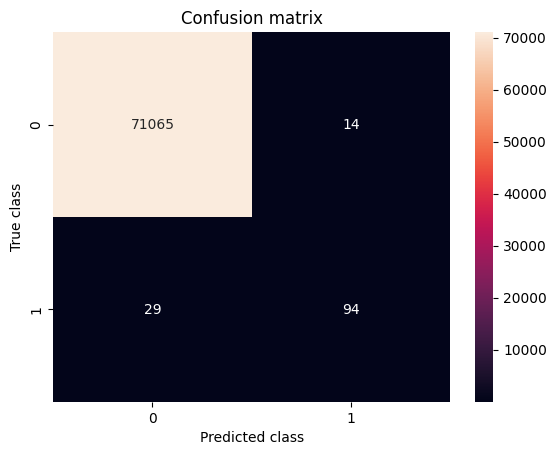

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(
                            random_state=0,
                            max_depth=10
                            )
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

show_metrics(y_train, y_test, y_pred_train, y_pred_test)

🔵 Reflexionemos sobre lo siguiente en el contexto del problema que estamos modelando:

* ¿Qué consecuencias tiene el recall bajo? Con el recall captamos los FN
* ¿Qué consecuencias tiene el precision bajo? Con el precision captamos los FP

### Modelo 2: Reescalamiento

Reescalamos los datos, no atendemos el desbalanceo de clases

Accuracy train: 0.9997471969289108
Accuracy test: 0.9993960843796522
------------------------------
Recall train: 0.8536585365853658
Recall test: 0.7642276422764228
------------------------------
Precision score train: 1.0
Precision score test: 0.8703703703703703
------------------------------


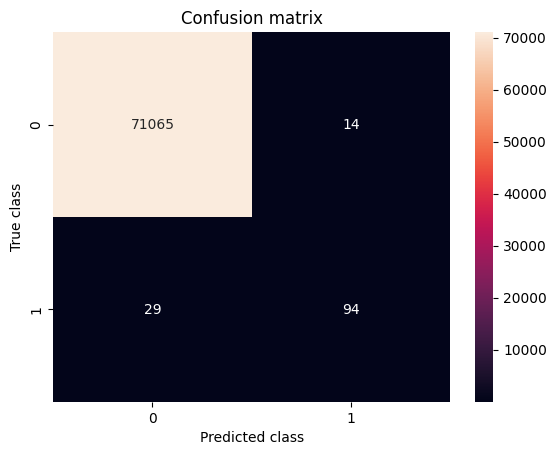

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(
                            random_state=0,
                            max_depth=10
                            )
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('classifier', clf)])

pipe.fit(X_train, y_train)

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

show_metrics(y_train, y_test, y_pred_train, y_pred_test)

### Modelo 3: SVC con Reescalamiento

Vemos un desempeño muy similar, recordemos que al Decision Tree no le afecta mucho la escala de los valores. Probemos con `SVC`:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy train: 0.9993633107839236
Accuracy test: 0.9994101289289626
------------------------------
Recall train: 0.8021680216802168
Recall test: 0.7967479674796748
------------------------------
Precision score train: 0.8245125348189415
Precision score test: 0.8521739130434782
------------------------------


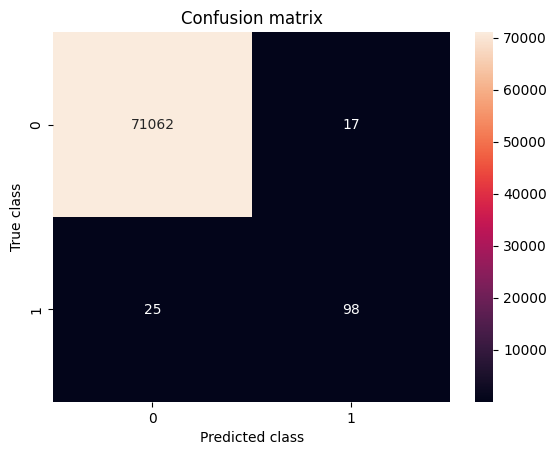

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('classifier', SVC(kernel='rbf', random_state=0))])

pipe.fit(X_train, y_train)

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

show_metrics(y_train, y_test, y_pred_train, y_pred_test)

## Desbalanceo

En esta sección abordaremos el problema del desbalanceo de clases usando varias estrategias:

1. Submuestreo
2. Sobremuestreo
3. SMOTE
4. Combinando estrategias

En todas las estrategias, recordar que es primero la división train/test y luego abordar el desbalanceo en la parte train solamente. Esto por dos razones:

1. **Evitar data leakage**: Haciendo undersampling antes de dividir, información del test set puede "filtrarse" al entrenamiento, ya que el muestreo se hace sobre datos que luego se separan. Esto inflaría artificialmente el rendimiento del modelo, porque el test set ya no sería totalmente independiente.

2. **Evaluación realista**: El test set debe reflejar la distribución original de los datos (desequilibrada), ya que en producción el modelo enfrentará datos similares. Si balanceamos el conjunto test, no podremos medir bien cómo se comporta el modelo en escenarios reales.

### 1. Submuestro: [`RandomUnderSampler`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html)




Obtenemos un conjunto de datos más balanceado que contenga el doble de instancias no fraudulentas respecto a las fraudulentas. De esta manera mantenemos la presencia mayoritaria de clases negativas pero sin el desbalance extremo.


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

print(f"Matriz de features: {X_train_undersampled.shape}")
print(f"Matriz de etiquetas: {y_train_undersampled.shape}")

Matriz de features: (1107, 30)
Matriz de etiquetas: (1107,)


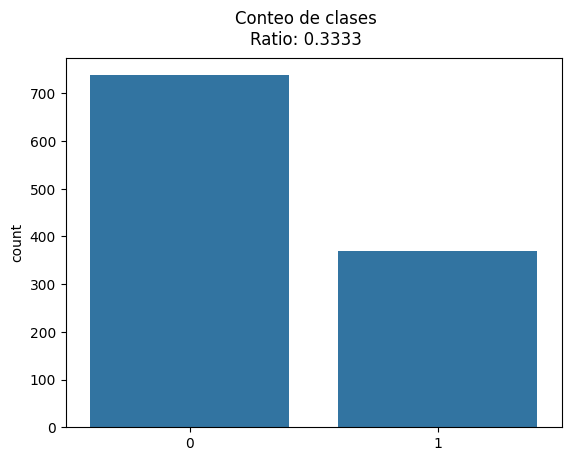

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ratio = y_train_undersampled[y_train_undersampled == 1].shape[0]/y_train_undersampled.shape[0]

plt.figure()
sns.countplot(x = y_train_undersampled)
plt.suptitle(f"Conteo de clases\nRatio: {round(ratio,4)}")
plt.show()

Accuracy train: 0.9467028003613369
Accuracy test: 0.9971770455886071
------------------------------
Recall train: 0.8428184281842819
Recall test: 0.8536585365853658
------------------------------
Precision score train: 0.9967948717948718
Precision score test: 0.3645833333333333
------------------------------


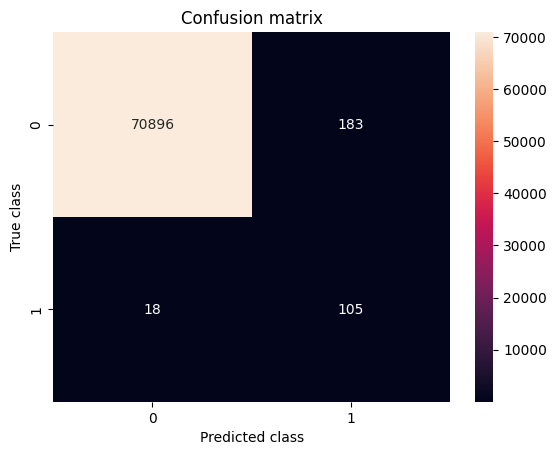

In [ ]:
pipeline = Pipeline([
                    ('scaler', MinMaxScaler()),
                    ('classifier', SVC(kernel='rbf', random_state=0))
                    ]
                    )

pipeline.fit(X_train_undersampled, y_train_undersampled)

y_pred_train = pipeline.predict(X_train_undersampled)
# y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

show_metrics(y_train_undersampled, y_test, y_pred_train, y_pred_test)
# show_metrics(y_train, y_test, y_pred_train, y_pred_test)

🔵 Mejoramos el test recall y empeoró el test precision. Es decir, el modelo mejoró respecto a los falsos negativos (fraudes no detectados) pero empeoró respecto a los falsos positivos (transacciones legítimas marcadas como fraude).

Probemos, además, selección de features.

Accuracy train: 0.948509485094851
Accuracy test: 0.997823094856886
------------------------------
Recall train: 0.8509485094850948
Recall test: 0.8699186991869918
------------------------------
Precision score train: 0.9936708860759493
Precision score test: 0.4349593495934959
------------------------------


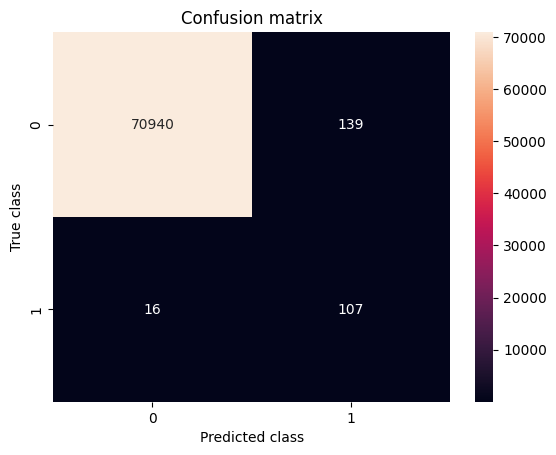

In [ ]:
from sklearn.feature_selection import SelectKBest

pipeline = Pipeline([
                    ('scaler', MinMaxScaler()),
                    ('selector', SelectKBest(k=10)),
                    ('classifier', SVC(kernel='rbf', random_state=0))
                    ]
                    )

pipeline.fit(X_train_undersampled, y_train_undersampled)

y_pred_train = pipeline.predict(X_train_undersampled)
# y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

show_metrics(y_train_undersampled, y_test, y_pred_train, y_pred_test)
# show_metrics(y_train, y_test, y_pred_train, y_pred_test)

⚡ Veamos las features seleccionadas

In [ ]:
feature_names = credito_df.columns.to_list()[:-1]
selected_features = [feature_names[k] for k in pipeline['selector'].get_support(indices=True)]
print(f"Features seleccionadas: {selected_features}")

Features seleccionadas: ['V3', 'V4', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']


Este es un modelo ligeramente mejor que el anterior en ambos aspectos.

### Oversampling: [`RandomOverSampler`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42, sampling_strategy=0.5)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)

print(f"Matriz de features: {X_train_oversampled.shape}")
print(f"Matriz de etiquetas: {y_train_oversampled.shape}")

Matriz de features: (319854, 30)
Matriz de etiquetas: (319854,)


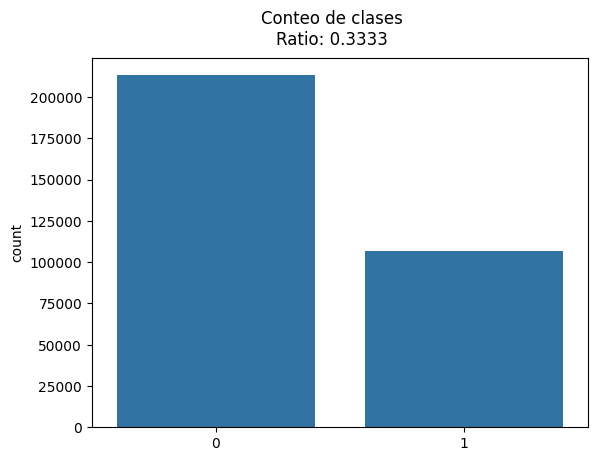

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ratio = y_train_oversampled[y_train_oversampled == 1].shape[0]/y_train_oversampled.shape[0]

plt.figure()
sns.countplot(x = y_train_oversampled)
plt.suptitle(f"Conteo de clases\nRatio: {round(ratio,4)}")
plt.show()

🔵 ¿Cuál es la diferencia con el undersampling?

Accuracy train: 0.9583184828077811
Accuracy test: 0.9943260020785933
------------------------------
Recall train: 0.8854133448385826
Recall test: 0.8861788617886179
------------------------------
Precision score train: 0.9883265630889065
Precision score test: 0.218436873747495
------------------------------


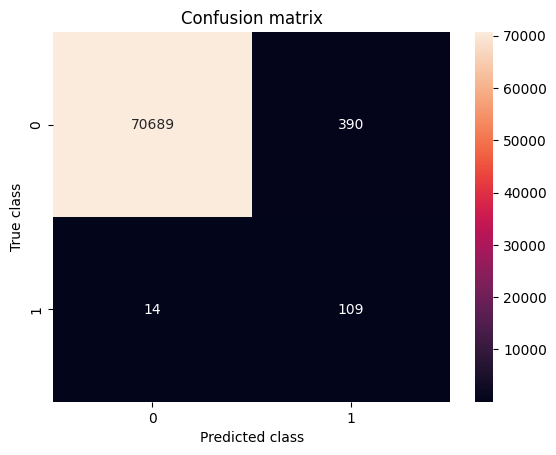

In [ ]:
from sklearn.feature_selection import SelectKBest

pipeline = Pipeline([
                    ('scaler', MinMaxScaler()),
                    ('selector', SelectKBest(k=10)),
                    ('classifier', SVC(kernel='rbf', random_state=0))
                    ]
                    )

pipeline.fit(X_train_oversampled, y_train_oversampled)

y_pred_train = pipeline.predict(X_train_oversampled)
# y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

show_metrics(y_train_oversampled, y_test, y_pred_train, y_pred_test)
# show_metrics(y_train, y_test, y_pred_train, y_pred_test)

### Oversampling: [`SMOTE`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)

Ahora haremos un proceso llamado [SMOTE: Synthetic Minority Over-sampling Technique](https://arxiv.org/abs/1106.1813)


In [ ]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train_undersampled, y_train_undersampled)

print(f"Matriz de features: {X_train_smote.shape}")
print(f"Matriz de etiquetas: {y_train_smote.shape}")

Matriz de features: (1476, 30)
Matriz de etiquetas: (1476,)


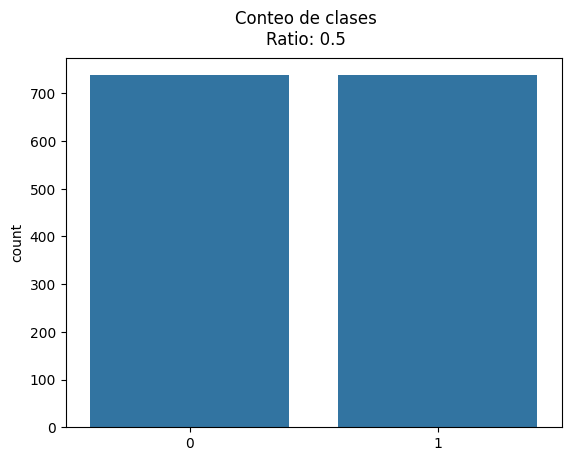

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ratio = y_train_smote[y_train_smote == 1].shape[0]/y_train_smote.shape[0]

plt.figure()
sns.countplot(x = y_train_smote)
plt.suptitle(f"Conteo de clases\nRatio: {round(ratio,4)}")
plt.show()

Accuracy train: 0.9471544715447154
Accuracy test: 0.9909693547934046
------------------------------
Recall train: 0.9051490514905149
Recall test: 0.8861788617886179
------------------------------
Precision score train: 0.9881656804733728
Precision score test: 0.14769647696476965
------------------------------


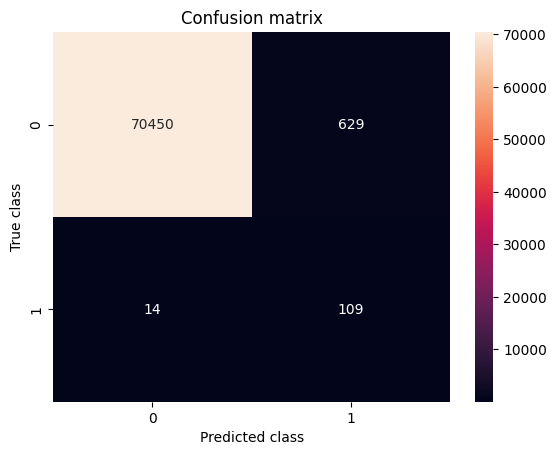

In [ ]:
from sklearn.feature_selection import SelectKBest

pipeline = Pipeline([
                    ('scaler', MinMaxScaler()),
                    ('selector', SelectKBest(k=10)),
                    ('classifier', SVC(kernel='rbf', random_state=0))
                    # ('classifier', RandomForestClassifier(class_weight='balanced'))
                    ]
                    )

pipeline.fit(X_train_smote, y_train_smote)

y_pred_train = pipeline.predict(X_train_smote)
# y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

show_metrics(y_train_smote, y_test, y_pred_train, y_pred_test)
# show_metrics(y_train, y_test, y_pred_train, y_pred_test)

🔵 Este es el peor modelo hasta el momento. El balance final con el SMOTE es demasiado agresivo, en el sentido de que se crean demasiados datos falsos no muy útiles.



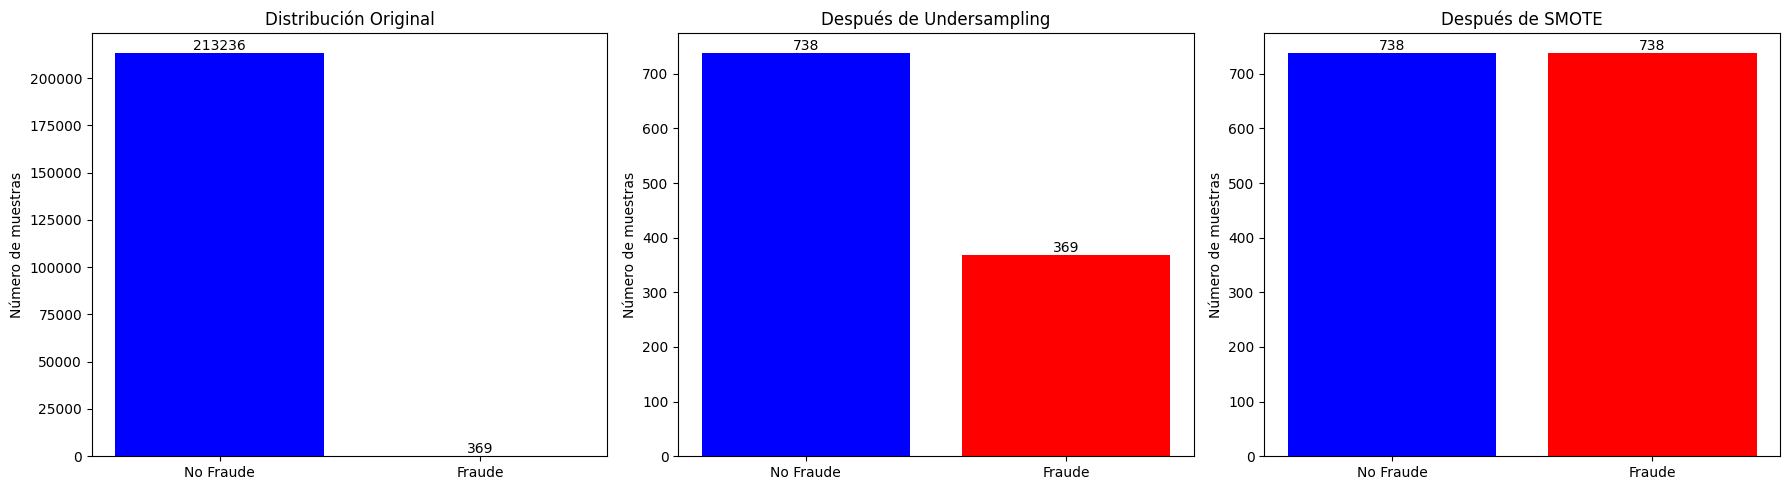

In [ ]:
#@title Proceso de balanceo

import matplotlib.pyplot as plt
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

under = RandomUnderSampler(sampling_strategy=0.5)  # Ratio 2:1
X_under, y_under = under.fit_resample(X_train, y_train)

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_under, y_under)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Función para graficar
def plot_distribution(y, ax, title):
    classes, counts = np.unique(y, return_counts=True)
    bars = ax.bar(classes, counts, color=['blue', 'red'])
    ax.set_xticks(classes)
    ax.set_xticklabels(['No Fraude', 'Fraude'])
    ax.set_title(title)
    ax.set_ylabel('Número de muestras')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

# Gráficas
plot_distribution(y_train, axes[0], "Distribución Original")
plot_distribution(y_under, axes[1], "Después de Undersampling")
plot_distribution(y_smote, axes[2], "Después de SMOTE")

plt.tight_layout()
plt.show()

Probemos un proceso de sobremuestreo más suave

Accuracy train: 0.9990215584841179
Accuracy test: 0.9986657678155108
------------------------------
Recall train: 1.0
Recall test: 0.8617886178861789
------------------------------
Precision score train: 0.6384083044982699
Precision score test: 0.5760869565217391
------------------------------


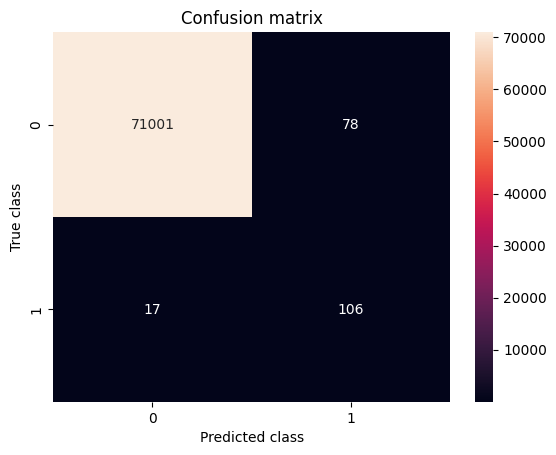

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

pipeline = Pipeline([
    ('under', RandomUnderSampler(sampling_strategy=0.1)),  # 10:1
    ('smote', SMOTE(sampling_strategy=0.2)),               # 5:1
    ('model', RandomForestClassifier(class_weight='balanced'))
])

pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

show_metrics(y_train, y_test, y_pred_train, y_pred_test)

🔽 Exploremos el balance de etiquetas a lo largo de este proceso:

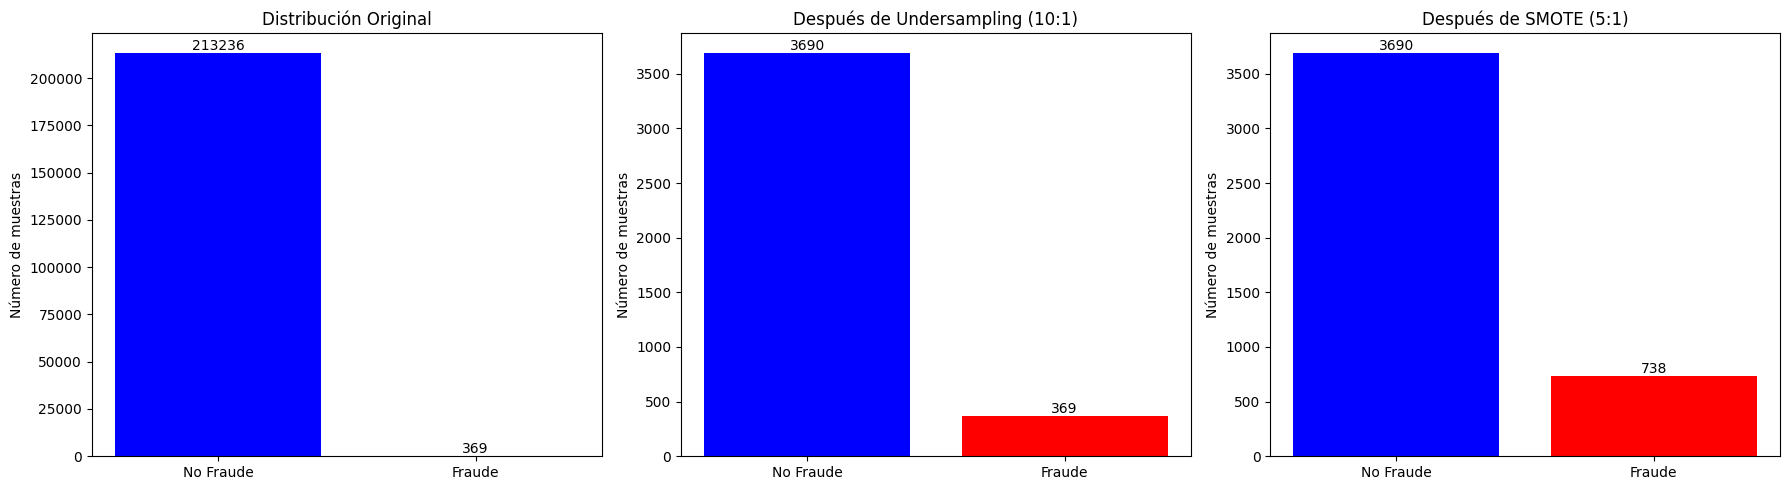

In [ ]:
#@title Proceso de balanceo

import matplotlib.pyplot as plt
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

under = RandomUnderSampler(sampling_strategy=0.1)  # Ratio 10:1
X_under, y_under = under.fit_resample(X_train, y_train)

smote = SMOTE(sampling_strategy=0.2)  # Ratio 5:1
X_smote, y_smote = smote.fit_resample(X_under, y_under)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráficas
plot_distribution(y_train, axes[0], "Distribución Original")
plot_distribution(y_under, axes[1], "Después de Undersampling (10:1)")
plot_distribution(y_smote, axes[2], "Después de SMOTE (5:1)")

plt.tight_layout()
plt.show()

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores hiperparámetros: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 200, 'selector__k': 'all'}
Mejor F1-score (validación): 0.9990492486755269
Accuracy train: 0.9992041384799045
Accuracy test: 0.9988202578579254
------------------------------
Recall train: 1.0
Recall test: 0.8617886178861789
------------------------------
Precision score train: 0.6846011131725418
Precision score test: 0.6127167630057804
------------------------------


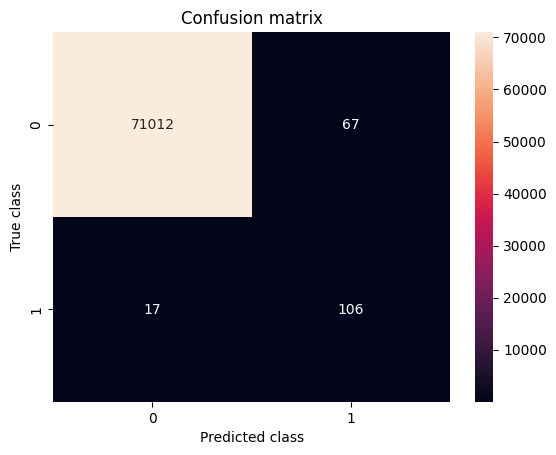

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, accuracy_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('under', RandomUnderSampler(sampling_strategy=0.1)),  # 10:1
    ('smote', SMOTE(sampling_strategy=0.2)),               # 5:1
    ('selector', SelectKBest(k=10)),
    ('model', RandomForestClassifier(class_weight='balanced'))
])

param_grid = {
    'selector__k': [5, 10, 20, 'all'],                   # Número de features
    'model__n_estimators': [50, 100, 200],               # Hiperparámetros de RandomForest
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
}

# 3. Métrica de evaluación (F1-score para clases desbalanceadas)
scorer = make_scorer(f1_score, average='weighted')

# 4. Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,                      # 5-fold cross-validation
    n_jobs=-1,                 # Usar todos los núcleos del servidor
    verbose=3                  # Mostrar logs detallados
)

grid_search.fit(X_train, y_train)

# 6. Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor F1-score (validación):", grid_search.best_score_)

y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)

show_metrics(y_train, y_test, y_pred_train, y_pred_test)

🔵 Este es el mejor modelo que tenemos hasta el momento.

A continuación se muestra el resultado de una busqueda de parámetros masiva:

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

pipeline = Pipeline([
    ('under', RandomUnderSampler(sampling_strategy=0.1)),  # 10:1
    ('smote', SMOTE(sampling_strategy=0.2)),               # 5:1
    ('model', RandomForestClassifier(class_weight='balanced'))
])

pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

show_metrics(y_train, y_test, y_pred_train, y_pred_test)